In [4]:
%run "examples/simulate_networks.py" # Modify this line to be /to/path/jf2016-tutorial/examples/simulate_networks.py

In [45]:
# Delete Cell
# %matplotlib inline
# # Import default
# import numpy as np
# import scipy as sp
# from scipy import linalg
# from sklearn.base import clone
# from sklearn.datasets import make_sparse_spd_matrix
# from matplotlib import pyplot as plt
# import seaborn as sns
# plt.ion()

# Import from skggm
import inverse_covariance as ic
from inverse_covariance import (
    QuicGraphLasso,
    QuicGraphLassoCV,
    QuicGraphLassoEBIC,
    AdaptiveGraphLasso,
    ModelAverage
)
from inverse_covariance.plot_util import trace_plot 

## Part I. Setup & Motivation

### Create Simulated Network

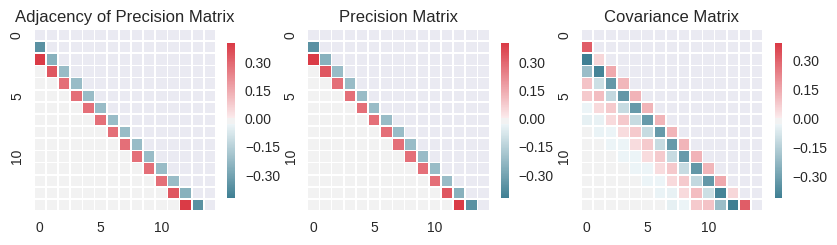

In [30]:
n_features = 15
adj_type = 'banded'
covariance, precision, adjacency = new_graph(15,.15,adj_type=adj_type,random_sign=True,seed=1)    
covariance2, precision2, adjacency2 = new_graph(15,.2,adj_type=adj_type,random_sign=True, seed=1)    

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

def compare_population_parameters(covariance,precision,adjacency):
    mask = np.zeros_like(precision, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.where(np.eye(np.shape(precision)[0]))] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    adj_vmax = np.max(np.triu(adjacency,1))
    sns.heatmap(adjacency,mask=mask,cmap=cmap, vmax=adj_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
    ax1.set_title('Adjacency of Precision Matrix')

    prec_vmax = np.max(np.triu(precision,1))
    sns.heatmap(precision,mask=mask,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
    ax2.set_title('Precision Matrix')

    cov_vmax = np.max(np.triu(covariance,1))
    sns.heatmap(covariance, mask=mask,cmap=cmap, vmax=cov_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax3)
    ax3.set_title('Covariance Matrix')
    
compare_population_parameters(covariance,precision,adjacency)    
# print "Check diagonals for precision and covariance"
# print [np.diag(precision), np.diag(covariance)]
# print "Check off diagonal maximum values"
# print np.round([adj_vmax, prec_vmax, cov_vmax],3)

### Example of Degeneracy in High Dimensions

Suppose we have two graphs that vary slightly in their degree. For example one with nodes with degree $=2$ and another with degree $=3$. 

- At large sample sizes, their sample covariances are distinguishable and a simple inverse precision matrix captures the original structure. 
- At small sample sizes both sample covariances and their precision counterparts become indistinguishable. 

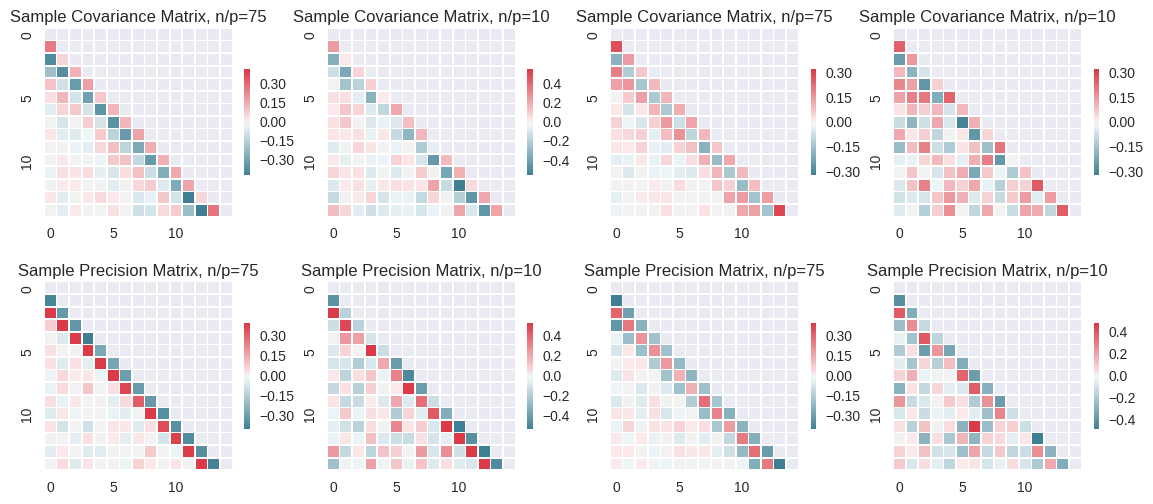

In [23]:
prng = np.random.RandomState(2)
X1 = mvn(75*n_features,n_features,covariance,random_state=prng)
X2 = mvn(10*n_features,n_features,covariance,random_state=prng)
X3 = mvn(75*n_features,n_features,covariance2,random_state=prng)
X4 = mvn(10*n_features,n_features,covariance2,random_state=prng)

f, ([ax1, ax2, ax5, ax7], [ax3, ax4, ax6, ax8]) = plt.subplots(2,4,figsize=(14,6));
cov_vmax = np.max(np.triu(covariance,1))
sns.heatmap(np.tril(np.cov(X1,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Sample Covariance Matrix, n/p=75')
sns.heatmap(np.tril(np.cov(X2,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Sample Covariance Matrix, n/p=10')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X1,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Sample Precision Matrix, n/p=75')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X2,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax4)
ax4.set_title('Sample Precision Matrix, n/p=10')
sns.heatmap(np.tril(np.cov(X3,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax5)
ax5.set_title('Sample Covariance Matrix, n/p=75')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X3,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax6)
ax6.set_title('Sample Precision Matrix, n/p=75')
sns.heatmap(np.tril(np.cov(X4,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax7)
ax7.set_title('Sample Covariance Matrix, n/p=10')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X4,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax8)
ax8.set_title('Sample Precision Matrix, n/p=10')

## Part II. Sparse Inverse Covariance via Penalized MLE

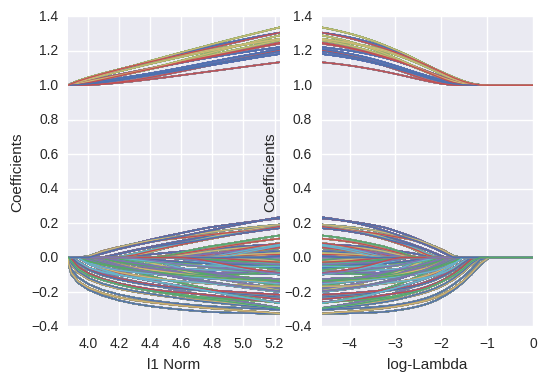

In [ ]:
# show graphical lasso path 
covariance, precision, adjacency = new_graph(15,.2,adj_type=adj_type,random_sign=True,seed=1)    
prng = np.random.RandomState(2)
X = mvn(20*n_features,n_features,covariance,random_state=prng)
path = np.logspace(np.log10(0.01), np.log10(1.0), num=25, endpoint=True)[::-1]
estimator = QuicGraphLasso(lam=1.0,path=path,mode='path')
estimator.fit(X)
trace_plot(estimator.precision_, estimator.path_)

### Model Selection: Cross-Validation versus EBIC

In [ ]:

metric='log_likelihood';
print 'QuicGraphLassoCV with:'
print '   metric: {}'.format(metric)
model = QuicGraphLassoCV(
        cv=2, # cant deal w more folds at small size
        n_refinements=6,
        n_jobs=1,
        init_method='cov',
        score_metric=metric)
model.fit(X)
cv_precision_ = model.precision_
print '   len(cv_lams): {}'.format(len(model.cv_lams_))
print '   lam_scale_: {}'.format(model.lam_scale_)
print '   lam_: {}'.format(model.lam_)



   len(path lams): 100
   lam_scale_: 1.06089448875
   lam_: 0.347395116004
   ebic_index: 12


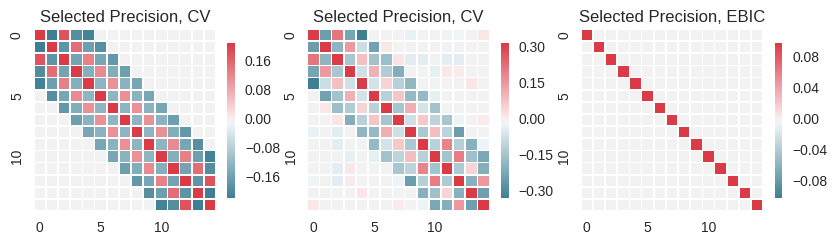

In [70]:
# EBIC
gamma = 0 # gamma = 0 (BIC), gamma=1 (Greater Sparsity)
model = QuicGraphLasso(
    lam=1.0,
    mode='path',
    init_method='cov',
    path=np.logspace(np.log10(0.0001), np.log10(1.0), num=100, endpoint=True))
model.fit(X)
ebic_index = model.ebic_select(gamma=gamma)
ebic_covariance_ = model.covariance_[ebic_index]
ebic_precision_ = model.precision_[ebic_index]
lam_ = model.lam_at_index(ebic_index)
print '   len(path lams): {}'.format(len(model.path_))
print '   lam_scale_: {}'.format(model.lam_scale_)
print '   lam_: {}'.format(lam_)
print '   ebic_index: {}'.format(ebic_index)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

prec_vmax = np.max(np.triu(adjacency,1))
sns.heatmap(adjacency,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Selected Precision, CV')

prec_vmax = np.max(np.triu(cv_precision_,1))
sns.heatmap(cv_precision_,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Selected Precision, CV')

prec_vmax = np.max(np.triu(ebic_precision_,1))
sns.heatmap(ebic_precision_,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Selected Precision, EBIC')

### Initial vs. Adaptive, High Sample Size

Difference in sparsity: 69,141
Frob Norm: 0.306759075467 (0.430268346601), Support Error: 36.0, False Pos: 36.0, False Neg: 0.0
Difference in sparsity: 69,93
Frob Norm: 0.48094601686 (0.420920858558), Support Error: 12.0, False Pos: 12.0, False Neg: 0.0



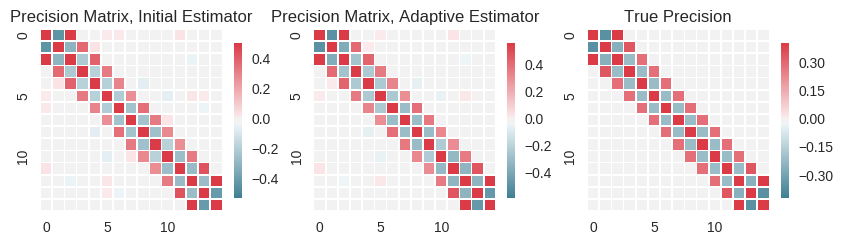

In [26]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

n_samples = 75*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

print 'n = {},p = {}'.format(n_samples,n_features)

def compare_init_adaptive(X,n_samples,n_features):
    # Initial Estimator
    initial_estimator = QuicGraphLassoCV(init_method='corrcoef')
    initial_estimator.fit(X)
    prec_hat = initial_estimator.precision_
    prec_vmax = np.max(np.triu(prec_hat,1))
    sns.heatmap(initial_estimator.precision_,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
    ax1.set_title('Precision Matrix, Initial Estimator')
    # Check Average Power
    err_frob, err_supp, err_fp, err_fn, err_inf =  ae_trial(
        trial_estimator=initial_estimator,
        n_samples=n_samples, 
        n_features=n_features, 
        cov=covariance, 
        adj=adjacency, 
        random_state=np.random.RandomState(2),X=X)
    print 'Difference in sparsity: {},{}'.format(
        np.sum(np.not_equal(precision,0)), 
        np.sum(np.not_equal(initial_estimator.precision_,0))
    )
    print 'Frob Norm: {} ({}), Support Error: {}, False Pos: {}, False Neg: {}'.format(
        err_frob, err_inf,
        err_supp,
        err_fp,
        err_fn
    )   
    # Adaptive Estimator
    twostage = AdaptiveGraphLasso(estimator=initial_estimator,method='inverse')
    twostage.fit(X)
    weighted_estimator = twostage.estimator_

    prec_hat = weighted_estimator.precision_
    prec_vmax = np.max(np.triu(prec_hat,1))
    sns.heatmap(weighted_estimator.precision_,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
    ax2.set_title('Precision Matrix, Adaptive Estimator')
    print 'Difference in sparsity: {},{}'.format(
        np.sum(np.not_equal(precision,0)), 
        np.sum(np.not_equal(weighted_estimator.precision_,0))
    )
    # Check Average Power
    err_frob, err_supp, err_fp, err_fn, err_inf =  ae_trial(
        trial_estimator=weighted_estimator,
        n_samples=n_samples, 
        n_features=n_features, 
        cov=covariance, 
        adj=adjacency, 
        random_state=np.random.RandomState(2), X = X)
    print 'Frob Norm: {} ({}), Support Error: {}, False Pos: {}, False Neg: {}'.format(
        err_frob,err_inf,
        err_supp,
        err_fp,
        err_fn
    )
    print 
    prec_vmax = np.max(np.triu(precision,1))
    sns.heatmap(adjacency,cmap=cmap, vmax=prec_vmax,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
    ax3.set_title('True Precision')

compare_init_adaptive(X,n_samples,n_features)

# Verification
# print 'Exact Recovery(T/F): {},  (TPR,FPR): {},  Count Diff: {}'.format(
#     exact_support(adjacency,precision),
#     approx_support(adjacency,precision,prob=0.1)[1:2],
#     count_support_diff(adjacency,precision),
# )


### Initial vs. Adaptive, Low Sample Size

n = 300,p = 15
Difference in sparsity: 69,149
Frob Norm: 0.443983868386 (0.967543998814), Support Error: 40.0, False Pos: 40.0, False Neg: 0.0
Difference in sparsity: 69,85
Frob Norm: 0.577134419057 (1.05238741376), Support Error: 8.0, False Pos: 8.0, False Neg: 0.0



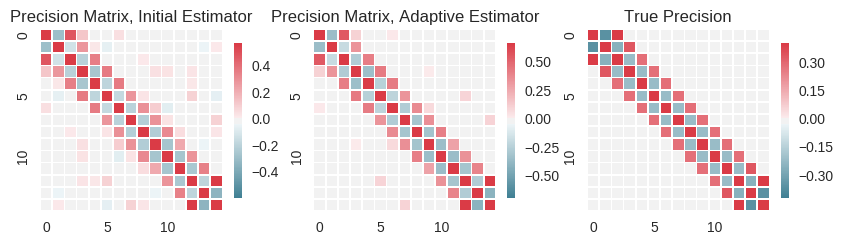

In [29]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

n_samples = 20*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print 'n = {},p = {}'.format(n_samples,n_features)

compare_init_adaptive(X,n_samples,n_features)


### Initial vs. Adaptive in Moderately Dense Graphs

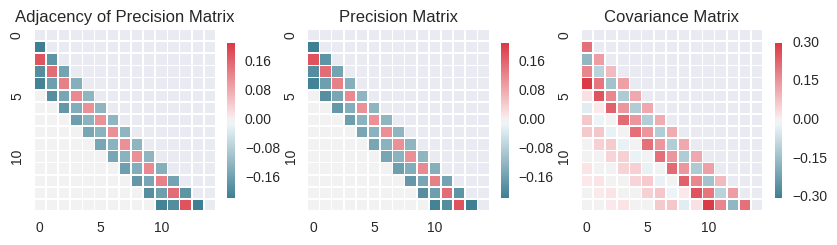

In [31]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));
covariance, precision, adjacency = new_graph(15,.4,adj_type=adj_type',random_sign=True,seed=1)    
compare_population_parameters(covariance,precision,adjacency)    

### High Sample Size

n = 1125,p = 15
Difference in sparsity: 115,169
Frob Norm: 0.312412241868 (0.520746458498), Support Error: 27.0, False Pos: 27.0, False Neg: 0.0
Difference in sparsity: 115,129
Frob Norm: 0.344734857898 (0.599308645621), Support Error: 7.0, False Pos: 7.0, False Neg: 0.0



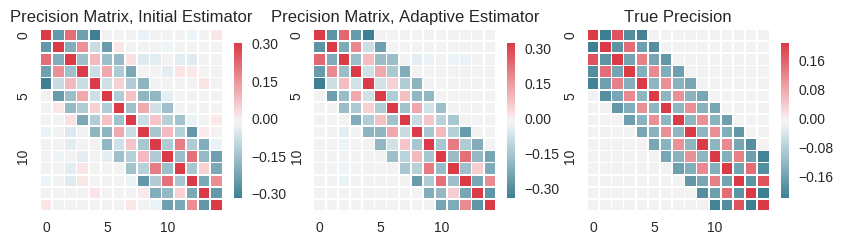

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

n_samples = 75*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print 'n = {},p = {}'.format(n_samples,n_features)

compare_init_adaptive(X,n_samples,n_features)

### Low Sample Size

n = 300,p = 15
Difference in sparsity: 115,135
Frob Norm: 0.567170517426 (1.02509054493), Support Error: 22.0, False Pos: 16.0, False Neg: 6.0
Difference in sparsity: 115,111
Frob Norm: 0.702817766604 (1.40414502038), Support Error: 18.0, False Pos: 8.0, False Neg: 10.0



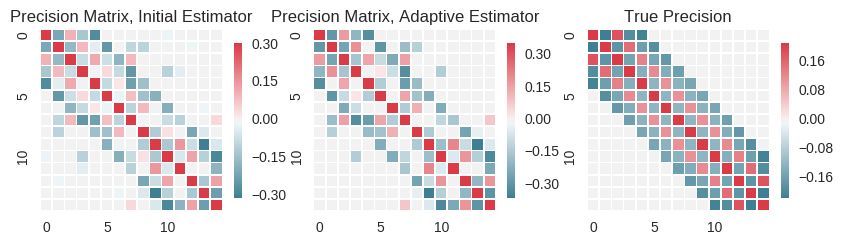

In [34]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

n_samples = 20*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)
print 'n = {},p = {}'.format(n_samples,n_features)

compare_init_adaptive(X,n_samples,n_features)

## Model Averaging

### High sparsity

In [ ]:
covariance, precision, adjacency = new_graph(15,.2,adj_type=adj_type',random_sign=True,seed=1)    

n_samples = 20*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

ensemble_estimator = ModelAverage(
            n_trials=20,
            penalization='random',
            lam=0.2)


### Moderate Sparsity

In [ ]:
covariance, precision, adjacency = new_graph(15,.4,adj_type=adj_type',random_sign=True,seed=1)    

n_samples = 20*n_features
prng = np.random.RandomState(2)
X = mvn(n_samples,n_features,covariance,random_state=prng)

ensemble_estimator = ModelAverage(
            n_trials=20,
            penalization='random',
            lam=0.2)